In [20]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split)
from dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
)
%load_ext skip_kernel_extension

## Loading Data

In [21]:
combined_df = pd.read_csv("preprocessed_data.csv")
combined_df = set_timestamp_index(combined_df,"Unnamed: 0")

In [22]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


## SVM


### Direct Multistep Prediction


Loading the data set

In [23]:

scaled_df = combined_df.copy(deep=True)

Scaling the data set

In [24]:

#Rescaling the data
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Creating Test-Train split

In [25]:

# Train-Test Split
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2015-01-01'
test_start_dt = '2017-01-01'
test_end_dt = '2017-01-04'

scaled_df.index.freq = 'h' 
(
    data_x_train,
    data_x_test,
    data_y_train,
    data_y_test,

) = create_test_train_split(
    scaled_df, train_start_dt, test_start_dt, test_end_dt, "total load actual", exog=None,
)


(17544, 26) (72, 26)
(17544, 1) (72, 1)


Hyperparameters

In [26]:

# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

Fitting the model to the training data

In [27]:

# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(data_x_train, data_y_train)

C:\Users\Benjamin\anaconda3\envs\env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(kernel='linear', tol=1e-05)

Getting model prediction scores

In [28]:

#Model Predictions:
#------------------
scoreTraining = model.score(data_x_train, data_y_train)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining)
print('-----------------------------------')
scoreValidation = model.score(data_x_test, data_y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

-----------------------------------
SVM Regression Training R^2 Score:  0.9985089708752417
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.9988882035521908
-----------------------------------


Model predictions

In [29]:

#Visual Comparisons
#------------------
# Let's get the predictions first:
y_predict = pd.Series(svr.predict(data_x_test),index=data_y_test.index)

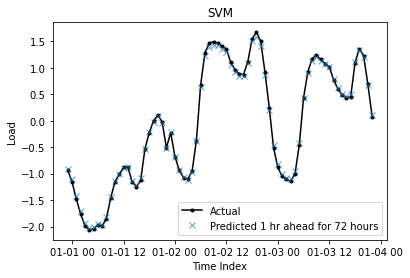

In [30]:

#Plotting the Figure:
plt.figure();
plt.plot(data_y_test, 'k.-');
plt.plot(y_predict, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead for 72 hours'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

### Recursive Multistep prediction


Loading the data set

In [31]:

scaled_df = combined_df.copy(deep=True)

Scaling the data set

In [32]:

#Rescaling the data
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Creating Test-Train split

In [33]:

# Train-Test Split
# We will split the data as training and test. No need for validation here. 
train_start_dt = '2015-01-01 00:00:00+1'
test_start_dt = '2017-01-01 00:00:00+1'
test_end_dt = '2017-01-04 00:00:00+1'

scaled_df.index.freq = 'h' 
(
    data_x_train,
    data_x_test,
    data_y_train,
    data_y_test,

) = create_test_train_split(
    scaled_df, train_start_dt, test_start_dt, test_end_dt, "total load actual", exog=None,
)


(17544, 26) (72, 26)
(17544, 1) (72, 1)


Hyperparameters

In [34]:


pd.options.mode.chained_assignment = None  # default='warn'

# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

Fitting the model to the training data

In [35]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(data_x_train, data_y_train)

C:\Users\Benjamin\anaconda3\envs\env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(kernel='linear', tol=1e-05)

In [36]:
y_predicted =pd.Series(index=data_y_test.index)

<ipython-input-36-7d4e31d3e9f7>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_predicted =pd.Series(index=data_y_test.index)


Model predictions

In [37]:
case_indices = data_y_test.index
window = 720
start_case_index = case_indices[0]-timedelta(hours=window)
end_case_index = case_indices[0]-timedelta(hours=1)
data_x_last = scaled_df[start_case_index:end_case_index]
dummy_array = np.zeros((1,data_x_last.shape[1])) 

for case_index in case_indices:
  # Predicting with fitted SVM(x_test_last)
  load_prediction = svr.predict(data_x_last).flatten()[0]
  # Preparing the next X_test_last:
  y_predicted.update(pd.Series(load_prediction,index=[case_index]))
  # scaling the load
  dummy_array[0,data_x_last.shape[1]-1] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,data_x_last.shape[1]-1]
  
  start_case_index = case_index-timedelta(hours=window-1)
  end_case_index=case_index

  data_x_last = scaled_df[start_case_index:end_case_index]
  #data_x_last['total load actual'] = data_x_last['total load actual'].replace(case_index,load_scaled)
  data_x_last.loc[case_index,'total load actual'] = load_scaled


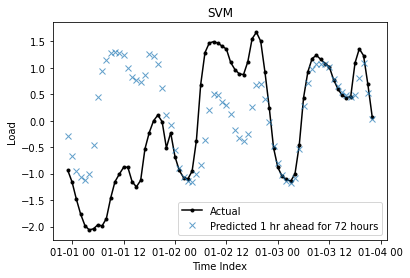

In [38]:

#Plotting the Figure:
plt.figure();
plt.plot(data_y_test, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead for 72 hours'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');